# Module 2: MRI Image Denoising

## Exercise 2.1: Visualisation and identifying noise

In this notebook, we'll work with k-space data from MRI and address common artifacts. The dataset contains a 3D knee image with six coil receivers. We need to identify and understand the noise characteristics to effectively denoise the images.

### 2.1.1: Load the complex data and determine the coil dimension

First, we'll load the k-space data and examine its shape to identify which dimension corresponds to the coils.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Define the data directory
data_dir = Path('../data/Module2')

# Load the k-space data
kspace_data = np.load(data_dir / 'kspace.npy')

# Print the shape of the data
print(f"Shape of k-space data: {kspace_data.shape}")
print(f"Data type: {kspace_data.dtype}")

# Determine which dimension is the coil dimension
# We expect to have 6 coils based on the problem description
for i, dim_size in enumerate(kspace_data.shape):
    if dim_size == 6:
        print(f"Dimension {i} has size 6, which likely corresponds to the coil dimension")


Shape of k-space data: (6, 280, 280)
Data type: complex128
Dimension 0 has size 6, which likely corresponds to the coil dimension


### 2.1.2 Create magnitude images of k-space for each coil

Now that we've identified the coil dimension, we'll create magnitude images of k-space for each coil. We'll use `np.log1p()` for easier visualization, which computes log(1+x) to avoid issues with zero values.

Number of coils: 6
Coil dimension: 0


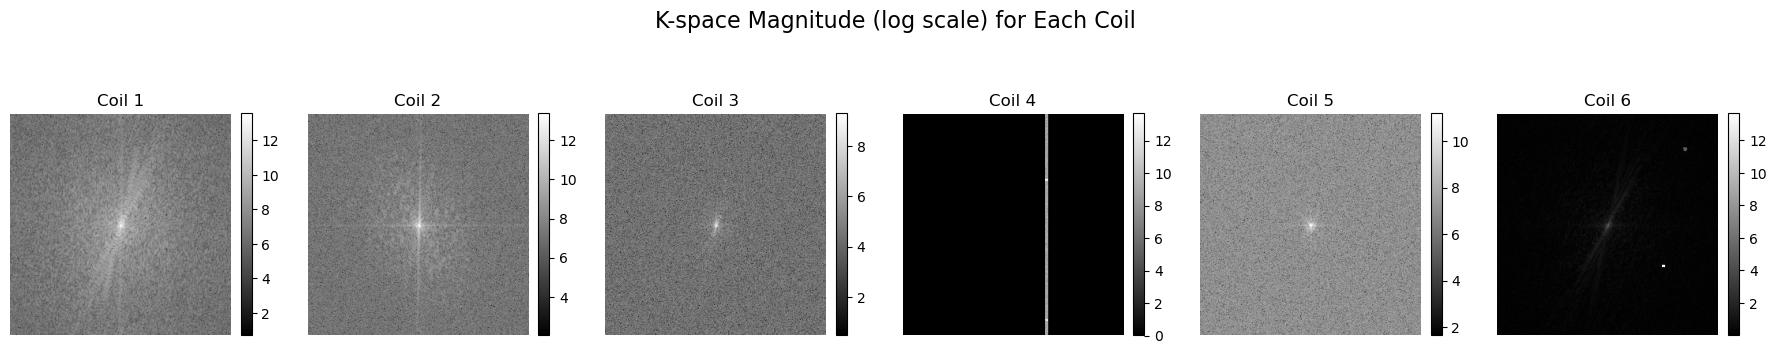

In [2]:
# Find the coil dimension (assuming it's the one with size 6 based on the problem)
coil_dim = None
for i, dim_size in enumerate(kspace_data.shape):
    if dim_size == 6:
        coil_dim = i
        break

# Number of coils
n_coils = kspace_data.shape[coil_dim]
print(f"Number of coils: {n_coils}")
print(f"Coil dimension: {coil_dim}")

# Function to plot k-space magnitude
def plot_kspace_magnitude(kspace_data, coil_dim):
    n_coils = kspace_data.shape[coil_dim]

    # Create a single-row figure with subplots for each coil
    fig, axes = plt.subplots(1, n_coils, figsize=(3 * n_coils, 4))  # wider layout for horizontal comparison

    # Ensure axes is always iterable (even if n_coils == 1)
    if n_coils == 1:
        axes = [axes]

    for coil_idx in range(n_coils):
        # Extract data for this coil
        if coil_dim == 0:
            coil_data = kspace_data[coil_idx, :, :]
        elif coil_dim == 1:
            coil_data = kspace_data[:, coil_idx, :]
        else:  # coil_dim == 2
            coil_data = kspace_data[:, :, coil_idx]

        # Apply fftshift to center the zero frequency component
        coil_data_shifted = np.fft.fftshift(coil_data)

        # Calculate magnitude and apply log scaling
        magnitude = np.abs(coil_data_shifted)
        log_magnitude = np.log1p(magnitude)

        # Plot
        im = axes[coil_idx].imshow(log_magnitude, cmap='gray')
        axes[coil_idx].set_title(f'Coil {coil_idx+1}')
        axes[coil_idx].axis("off")
        plt.colorbar(im, ax=axes[coil_idx], fraction=0.046, pad=0.04)

    plt.suptitle('K-space Magnitude (log scale) for Each Coil', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


# Plot k-space magnitude for each coil
plot_kspace_magnitude(kspace_data, coil_dim)


**About FFT Shifting in K-space**

When visualizing k-space data, it's important to use `np.fft.fftshift` to rearrange the frequency components so that the zero-frequency component (DC component) is at the center of the spectrum rather than at the corners. This makes the visualization more intuitive, as MRI k-space typically has the highest signal intensity at the center (low spatial frequencies) which gradually decreases toward the periphery (high spatial frequencies).

Without FFT shifting:
- The zero-frequency component is at the corners
- The high frequencies appear in the center
- This creates a less intuitive visualization where the bright spots are in the corners

With FFT shifting:
- The zero-frequency component is centered
- High frequencies appear at the edges
- This matches the conventional way of displaying k-space with bright center and darker edges

### 2.1.3 Transform data to image space using Fourier transform

We'll now transform the k-space data to image space using the inverse Fourier transform. MRI data in k-space needs to be converted to image space for visualization and analysis.

### 2.1.4 Display magnitude and phase images from a single coil

Now we'll display both the magnitude and phase of the image space data for one coil. This allows us to examine the reconstructed image and understand the phase information, which is important in MRI analysis.

In [3]:
# Function to get data for a specific coil
def get_coil_data(data, coil_dim, coil_idx):
    if coil_dim == 0:
        return data[coil_idx, :, :]
    elif coil_dim == 1:
        return data[:, coil_idx, :]
    else:  # coil_dim == 2
        return data[:, :, coil_idx]

# Transform k-space data to image space for all coils
image_data = np.zeros_like(kspace_data)
for coil_idx in range(n_coils):
    # Get k-space data for this coil
    coil_kspace = get_coil_data(kspace_data, coil_dim, coil_idx)
    
    # Apply inverse Fourier transform
    coil_image = np.fft.ifft2(coil_kspace)
    
    # Store in the image data array
    if coil_dim == 0:
        image_data[coil_idx, :, :] = coil_image
    elif coil_dim == 1:
        image_data[:, coil_idx, :] = coil_image
    else:  # coil_dim == 2
        image_data[:, :, coil_idx] = coil_image

In [4]:
# import matplotlib.pyplot as plt
# import numpy as np

# # all coil's magnitude（log1p）scale
# def show_log_magnitude_images(image_data, coil_dim):
#     n_coils = image_data.shape[coil_dim]
    
#     plt.figure(figsize=(15, 5))
#     for coil_idx in range(n_coils):
#         if coil_dim == 0:
#             coil_img = image_data[coil_idx, :, :]
#         elif coil_dim == 1:
#             coil_img = image_data[:, coil_idx, :]
#         else:
#             coil_img = image_data[:, :, coil_idx]
        
#         mag_log = np.log1p(np.abs(coil_img))

        
#         plt.subplot(1, n_coils, coil_idx + 1)
#         plt.imshow(mag_log, cmap="gray")
#         plt.axis("off")
#         plt.title(f"Magnitude Image Coil {coil_idx + 1}")
    
#     # plt.suptitle("Log-Scaled Magnitude Images from Each Coil")
#     plt.tight_layout()
#     plt.show()

# show_log_magnitude_images(image_data, coil_dim)

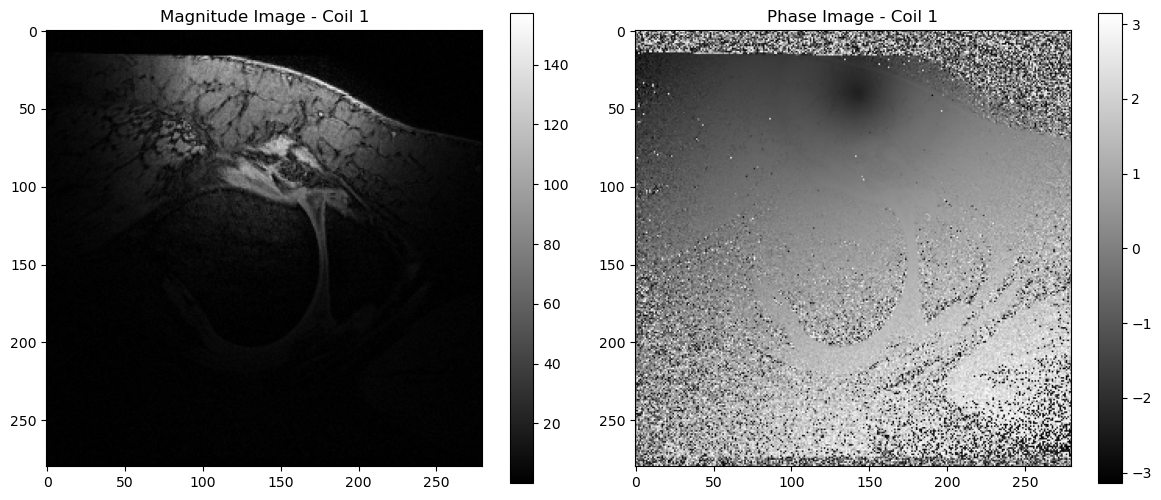

In [5]:
# Create and show magnitude and phase image from the first coil
first_coil_image = get_coil_data(image_data, coil_dim, 0)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(np.abs(first_coil_image), cmap='gray')
plt.title('Magnitude Image - Coil 1')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.angle(first_coil_image), cmap='gray')
plt.title('Phase Image - Coil 1')
plt.colorbar()
plt.tight_layout()
plt.show()

### 2.1.5 Show magnitude images from all coils

Next, we'll display the magnitude images from all coils to observe the spatial sensitivity profiles of each coil. Different coils capture signals from different parts of the anatomy with varying degrees of sensitivity.

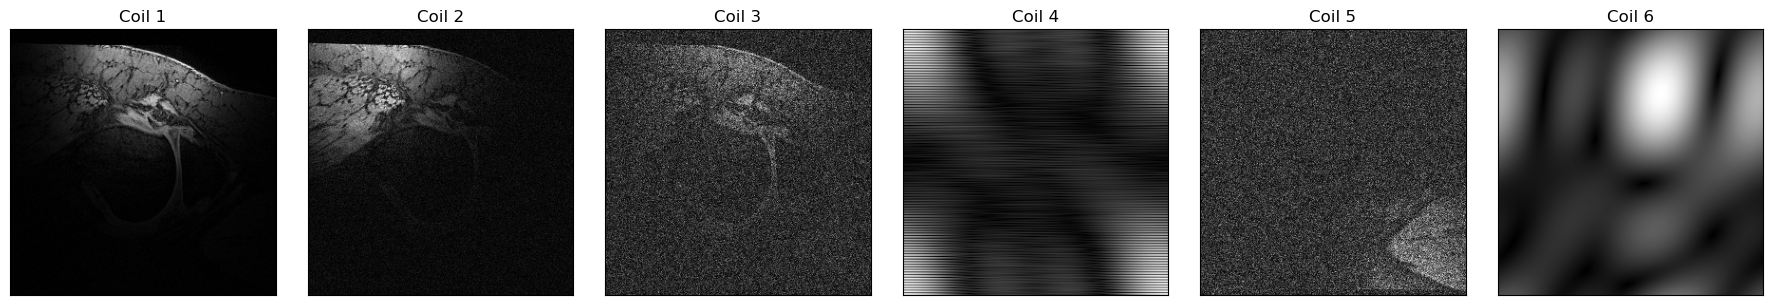

In [6]:
# Show magnitude images from all coils in one row (1x6), no colorbar, no axis ticks
plt.figure(figsize=(18, 3))  # Wide figure for horizontal layout

for coil_idx in range(n_coils):
    plt.subplot(1, n_coils, coil_idx + 1)
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    plt.imshow(np.abs(coil_image), cmap='gray')
    plt.title(f'Coil {coil_idx + 1}')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()

### 2.1.6 Combine data from all coils using root-sum-of-squares method

Now we'll combine the data from all coils into a single image using the root-sum-of-squares method, which is a common technique for combining multi-coil MRI data. This method maximizes the signal-to-noise ratio while preserving image contrast.

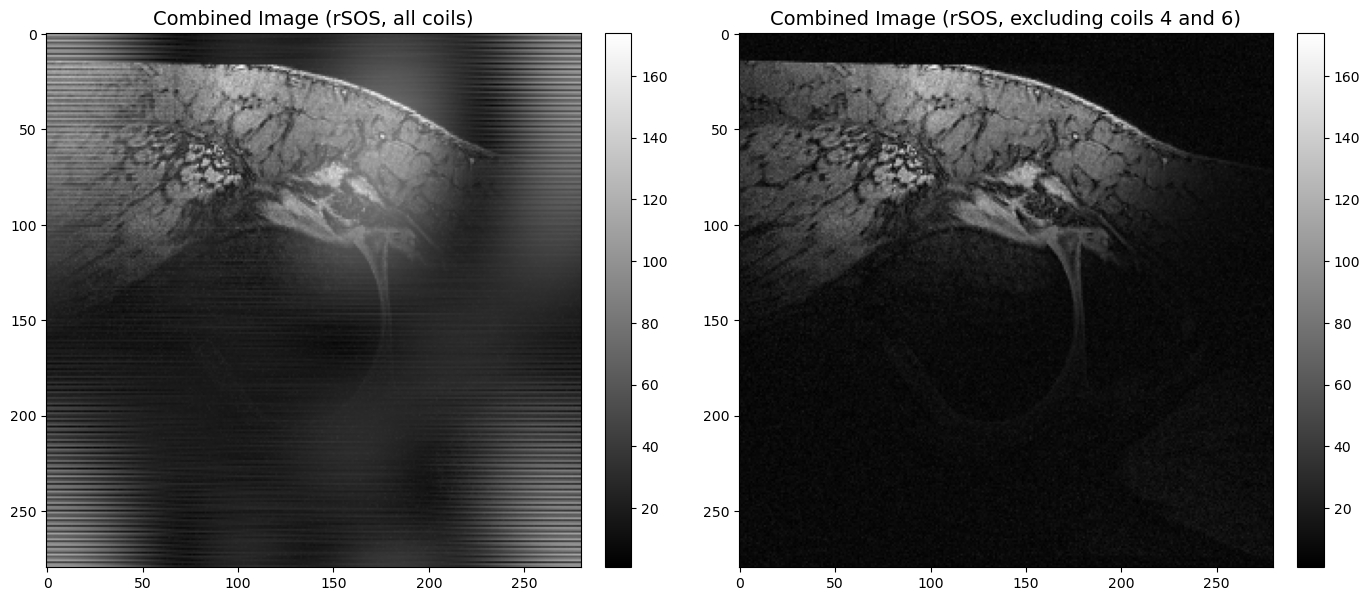

In [7]:
# Compute full rSOS with all coils
combined_all = np.zeros(first_coil_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_all += np.abs(coil_image) ** 2
combined_all = np.sqrt(combined_all)

# Compute rSOS excluding coil 4 and 6 (indices 3 and 5)
combined_partial = np.zeros(first_coil_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    if coil_idx in [3, 5]:
        continue
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_partial += np.abs(coil_image) ** 2
combined_partial = np.sqrt(combined_partial)

# Determine common color scale range
vmin = min(combined_all.min(), combined_partial.min())
vmax = max(combined_all.max(), combined_partial.max())

# Plot side-by-side with consistent colorbar
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(combined_all, cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Combined Image (rSOS, all coils)', fontsize=14)

im1 = axes[1].imshow(combined_partial, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('Combined Image (rSOS, excluding coils 4 and 6)', fontsize=14)


# Add colorbars (one per image)
cbar0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
cbar1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

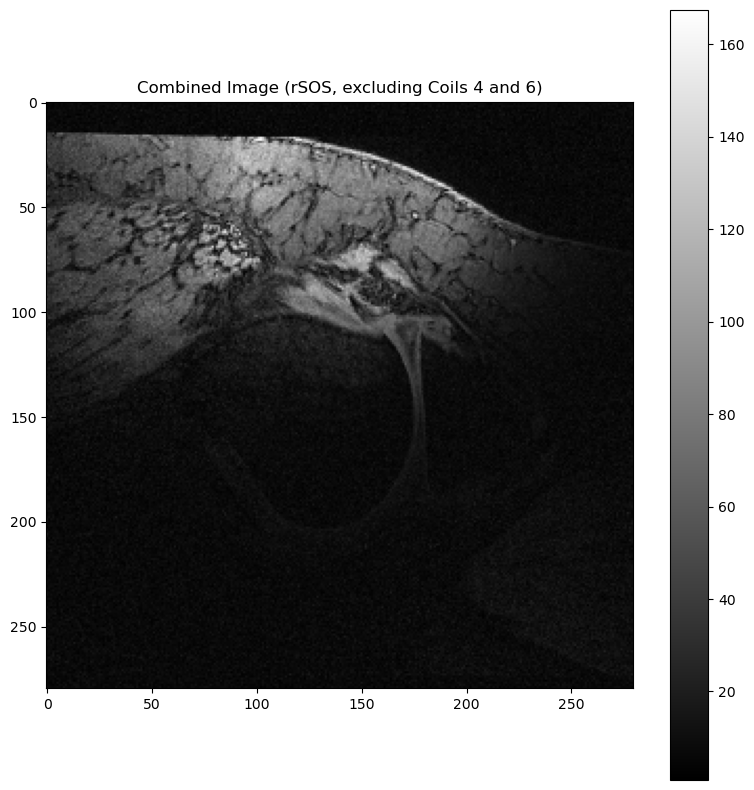

In [8]:
# Combine data from selected coils using root sum of squares (rSOS)
# Ignoring coil 4 (index 3) and coil 6 (index 5)

combined_image = np.zeros(first_coil_image.shape, dtype=np.float64)

# Only include coils 0, 1, 2, 4 (index 0, 1, 2, 4) if n_coils = 6
for coil_idx in range(n_coils):
    if coil_idx in [3, 5]:  # Skip coil 4 and 6
        continue
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_image += np.abs(coil_image) ** 2

# Take square root to finish rSOS
combined_image = np.sqrt(combined_image)

# Show the combined image
plt.figure(figsize=(8, 8))
plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image (rSOS, excluding Coils 4 and 6)')
plt.colorbar()
plt.tight_layout()
plt.show()

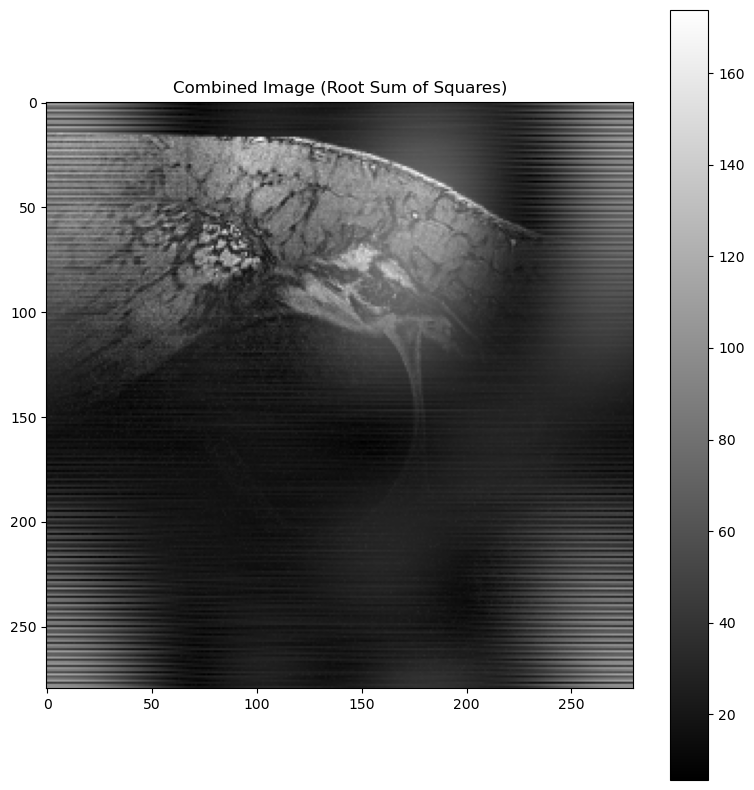

In [9]:
# Combine data from all coils using root sum of squares (rSOS)
# First, square the magnitude of each coil
combined_image = np.zeros(first_coil_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_image += np.abs(coil_image)**2

# Take the square root of the sum
combined_image = np.sqrt(combined_image)

# Show the combined image
plt.figure(figsize=(8, 8))
plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image (Root Sum of Squares)')
plt.colorbar()
plt.tight_layout()
plt.show()

### 2.1.7: Analyze our observations

1. The k-space data shows bright regions in the center for most coils, indicating strong low-frequency components.
2. Coil 4 appears to have very little signal, possibly due to poor positioning or malfunction.
3. Coil 6 shows a unique pattern compared to others, possibly capturing different anatomical structures.
4. The magnitude images show varying sensitivity patterns across coils, with some capturing certain regions better than others.
5. The combined image shows improved signal-to-noise ratio compared to individual coil images.
6. The phase images contain wrapping artifacts, which is typical in MRI phase data.

## Exercise 2.2: Removing noise

In this part of the exercise, we'll focus on applying various denoising methods to improve the quality of our MRI images. We'll:

1. Apply three different denoising methods to the image space data for all coils
2. Apply a Butterworth filter to the k-space data for the first coil
3. Create a new combined image using one of our denoising methods
4. Discuss potential methods to further improve image quality

We'll use advanced techniques and proper methodology to ensure optimal results and thorough analysis.

### 2.2.1 Apply Choose three denoising methods: Gaussian, Bilateral, Wavelet

Shape of k-space data: (6, 280, 280)
Data type: complex128
Dimension 0 has size 6, which likely corresponds to the coil dimension
Number of coils: 6
Coil dimension: 0


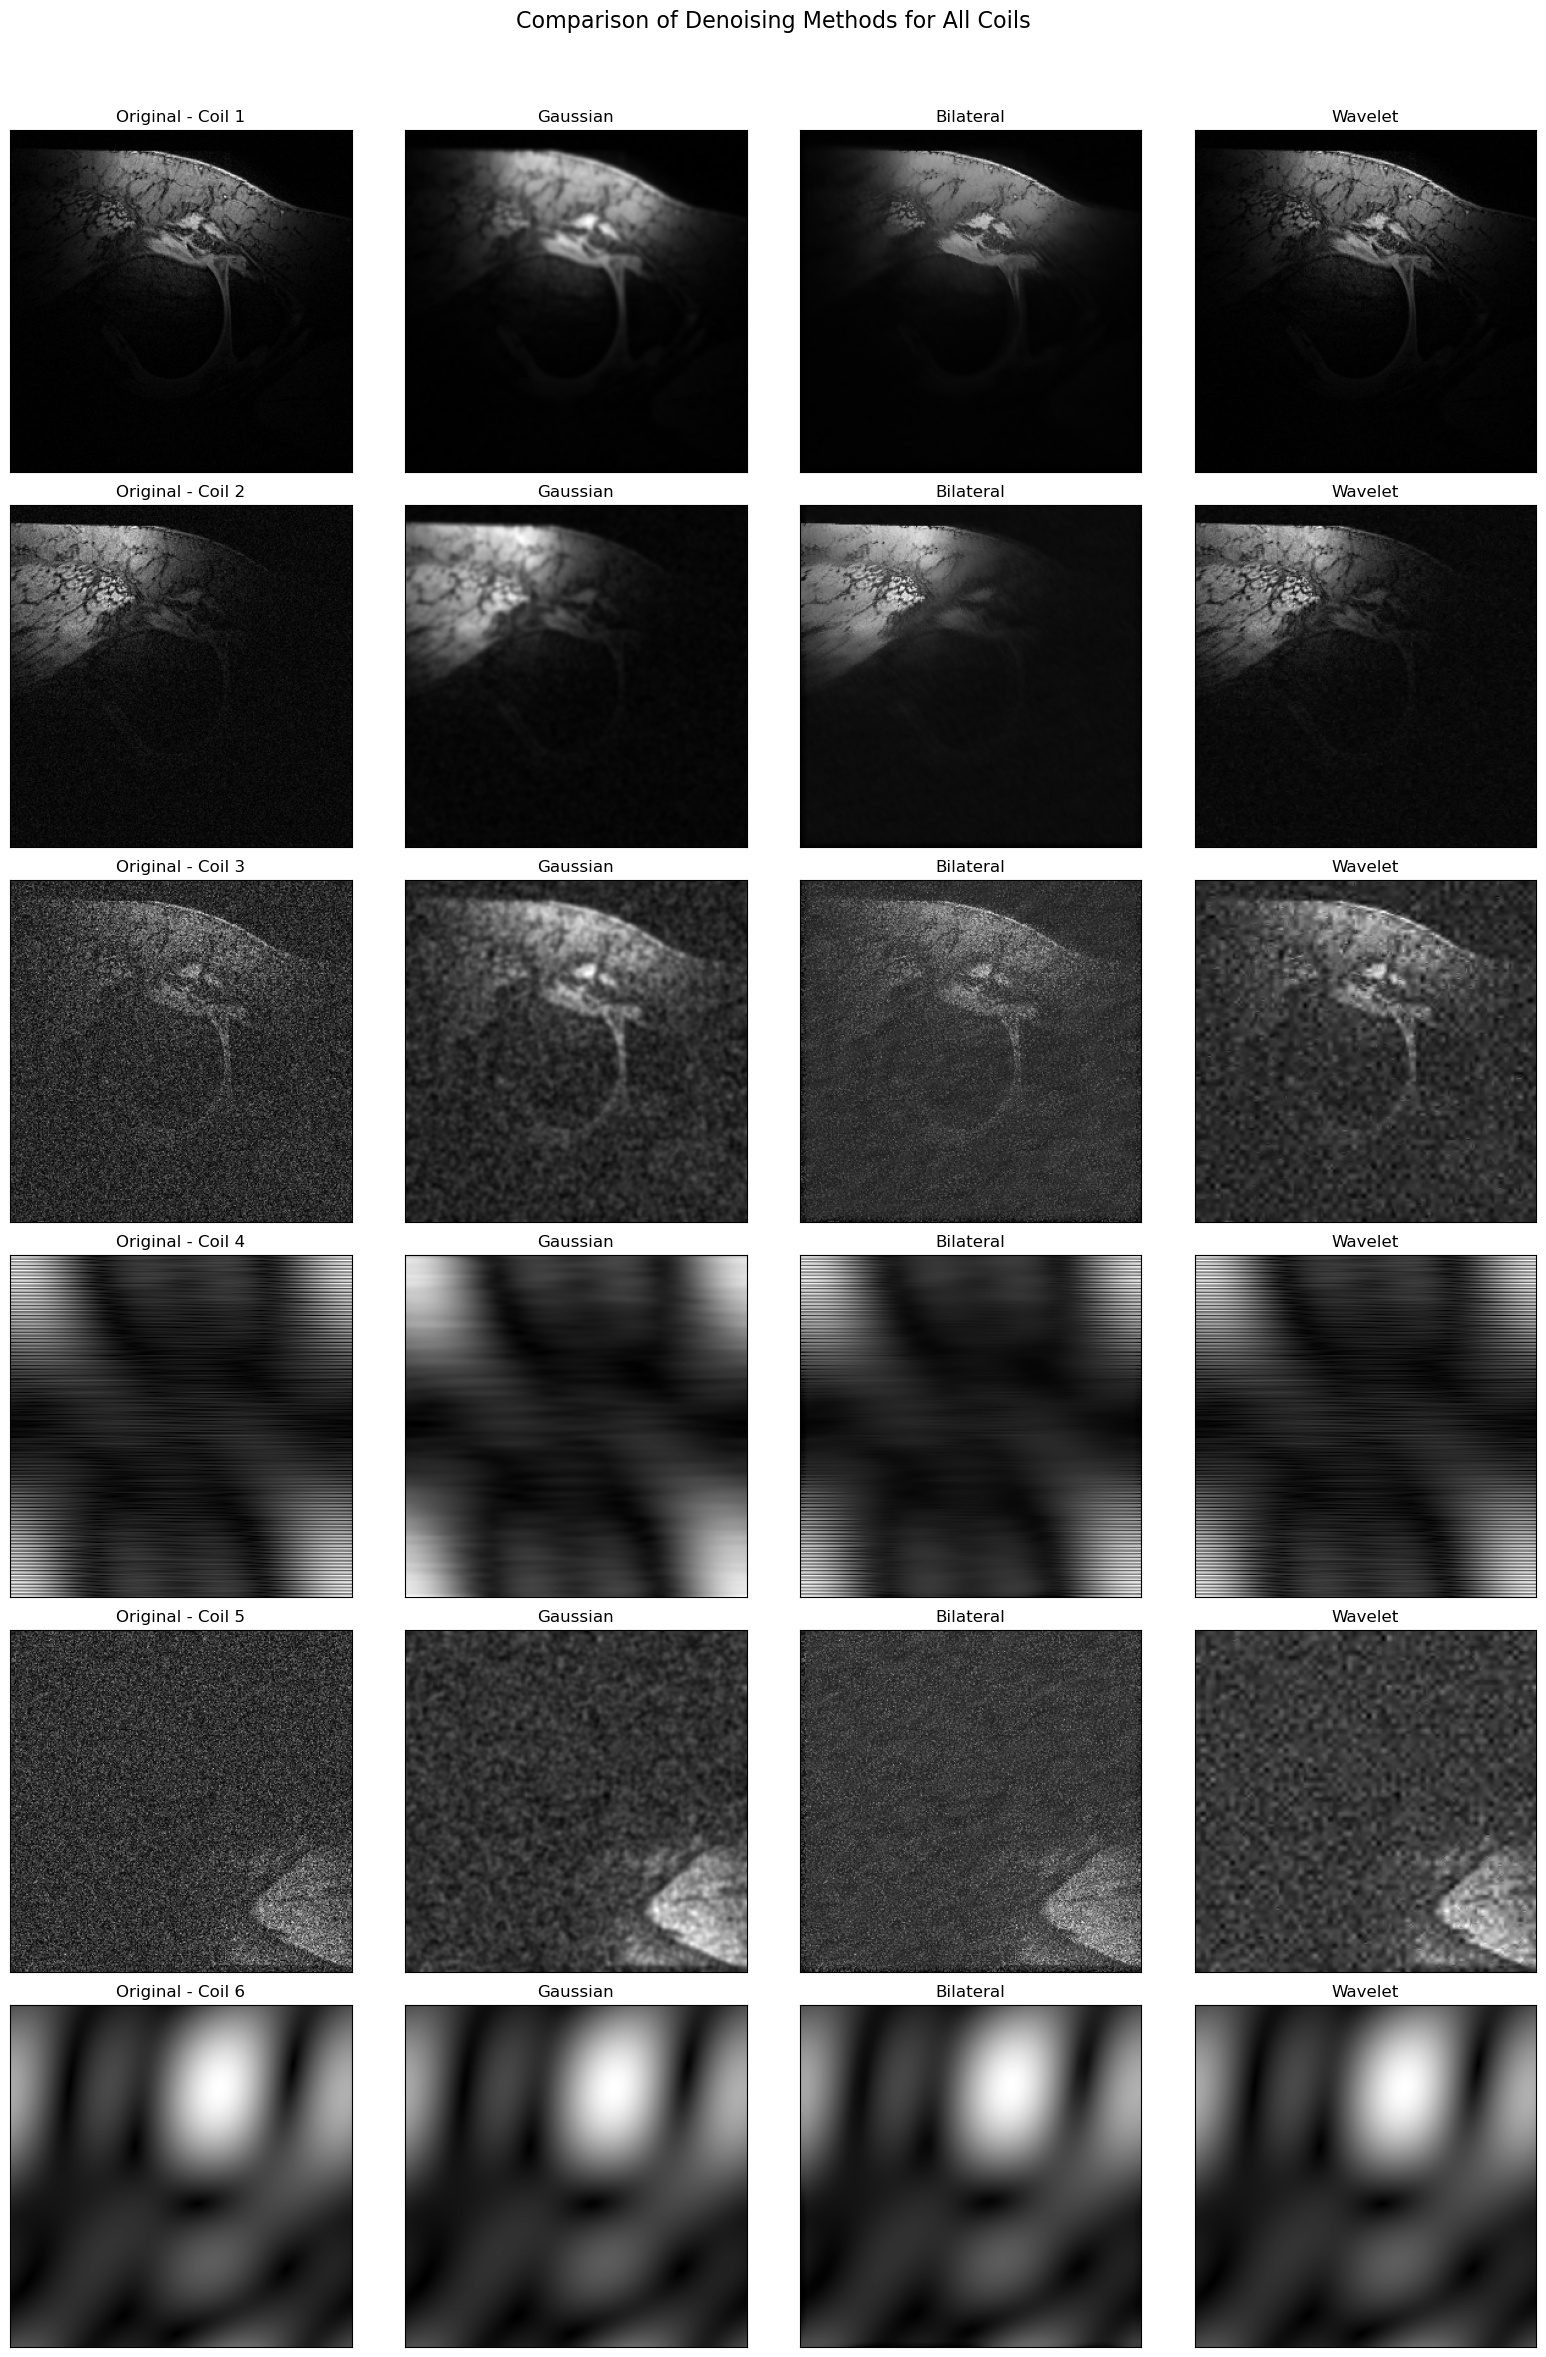

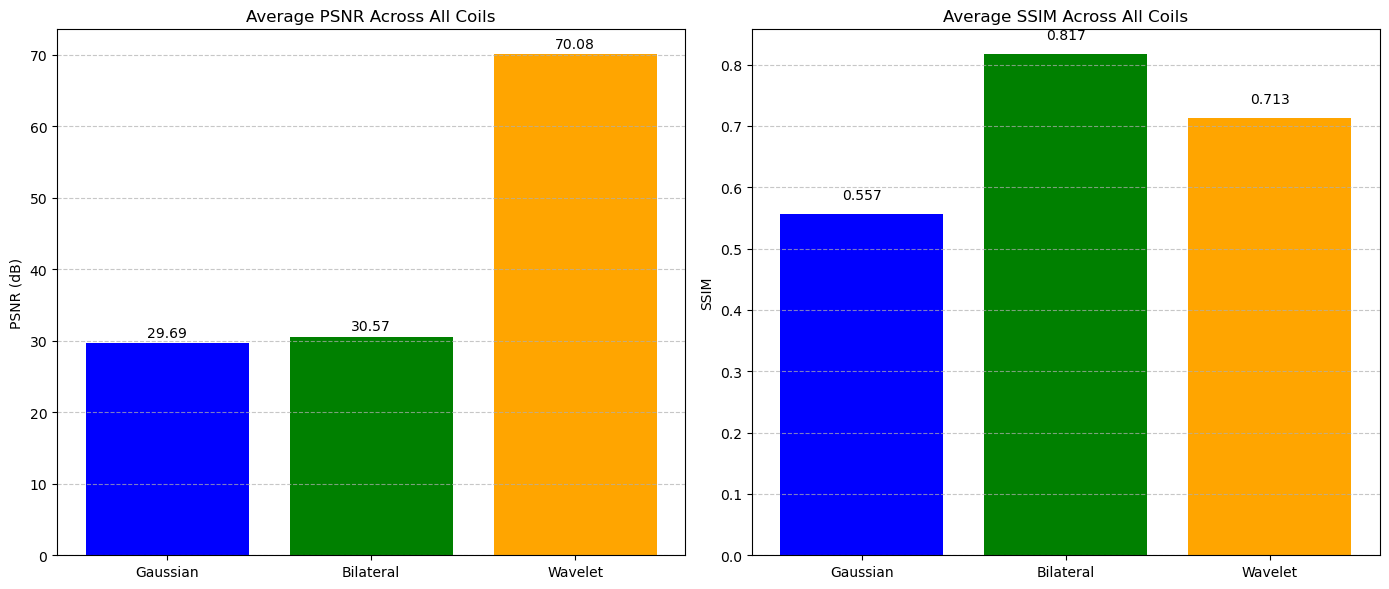


Metrics for Each Coil and Denoising Method
   Coil   |    Method     |   PSNR (dB)   |     SSIM      
--------------------------------------------------------------------------------
  Coil 1  |   Gaussian    |     29.84     |     0.875     
          |   Bilateral   |     32.75     |     0.878     
          |    Wavelet    |     54.84     |     0.997     
--------------------------------------------------------------------------------
  Coil 2  |   Gaussian    |     27.64     |     0.625     
          |   Bilateral   |     30.38     |     0.667     
          |    Wavelet    |     35.39     |     0.866     
--------------------------------------------------------------------------------
  Coil 3  |   Gaussian    |     20.57     |     0.216     
          |   Bilateral   |     26.00     |     0.801     
          |    Wavelet    |     20.64     |     0.237     
--------------------------------------------------------------------------------
  Coil 4  |   Gaussian    |     21.52     

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_bilateral, denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Define the data directory
data_dir = Path('../data/Module2')

# Load the k-space data
kspace_data = np.load(data_dir / 'kspace.npy')

# Print the shape of the data
print(f"Shape of k-space data: {kspace_data.shape}")
print(f"Data type: {kspace_data.dtype}")

# Find the coil dimension
coil_dim = None
for i, dim_size in enumerate(kspace_data.shape):
    if dim_size == 6:
        coil_dim = i
        print(f"Dimension {i} has size 6, which likely corresponds to the coil dimension")
        coil_dim = i
        break

# Number of coils
n_coils = kspace_data.shape[coil_dim]
print(f"Number of coils: {n_coils}")
print(f"Coil dimension: {coil_dim}")

# Function to get data for a specific coil
def get_coil_data(data, coil_dim, coil_idx):
    if coil_dim == 0:
        return data[coil_idx, :, :]
    elif coil_dim == 1:
        return data[:, coil_idx, :]
    else:  # coil_dim == 2
        return data[:, :, coil_idx]

# Transform k-space data to image space for all coils
image_data = np.zeros_like(kspace_data)
for coil_idx in range(n_coils):
    # Get k-space data for this coil
    coil_kspace = get_coil_data(kspace_data, coil_dim, coil_idx)
    
    # Apply inverse Fourier transform
    coil_image = np.fft.ifft2(coil_kspace)
    
    # Store in the image data array
    if coil_dim == 0:
        image_data[coil_idx, :, :] = coil_image
    elif coil_dim == 1:
        image_data[:, coil_idx, :] = coil_image
    else:  # coil_dim == 2
        image_data[:, :, coil_idx] = coil_image

# 1. Gaussian Filter
def apply_gaussian_filter(image, sigma=1.0):
    return gaussian_filter(image, sigma=sigma)

# 2. Bilateral Filter - Updated for newer scikit-image versions
def apply_bilateral_filter(image, sigma_spatial=1.0, sigma_color=0.1):
    return denoise_bilateral(
        image, 
        sigma_color=sigma_color,
        sigma_spatial=sigma_spatial,
        channel_axis=None
    )

# 3. Wavelet Denoising - Updated for newer scikit-image versions
def apply_wavelet_denoising(image, wavelet='db4', mode='soft'):
    return denoise_wavelet(
        image, 
        wavelet=wavelet, 
        mode=mode, 
        channel_axis=None
    )

# Apply each denoising method to all coils
denoised_gaussian = np.zeros_like(image_data, dtype=np.complex128)
denoised_bilateral = np.zeros_like(image_data, dtype=np.complex128)
denoised_wavelet = np.zeros_like(image_data, dtype=np.complex128)

# Metrics storage
metrics = {
    'gaussian': {'psnr': [], 'ssim': []},
    'bilateral': {'psnr': [], 'ssim': []},
    'wavelet': {'psnr': [], 'ssim': []}
}

for coil_idx in range(n_coils):
    # Get image data for this coil
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    
    # Apply denoising to magnitude and preserve phase
    magnitude = np.abs(coil_image)
    phase = np.angle(coil_image)
    
    # Create noise reference by adding Gaussian noise
    # This is just to have a reference for computing metrics
    noise_level = 0.05 * np.mean(magnitude)
    noisy_magnitude = magnitude + np.random.normal(0, noise_level, magnitude.shape)
    
    # Normalize magnitude to [0,1] for some methods that expect this range
    mag_min, mag_max = np.min(magnitude), np.max(magnitude)
    magnitude_norm = (magnitude - mag_min) / (mag_max - mag_min) if mag_max > mag_min else magnitude
    
    # Apply each denoising method
    gaussian_magnitude = apply_gaussian_filter(magnitude, sigma=1.5)
    bilateral_magnitude = apply_bilateral_filter(magnitude_norm, sigma_spatial=2.0, sigma_color=0.1)
    wavelet_magnitude = apply_wavelet_denoising(magnitude_norm, wavelet='db4', mode='soft')
    
    # Denormalize for bilateral and wavelet
    bilateral_magnitude = bilateral_magnitude * (mag_max - mag_min) + mag_min
    wavelet_magnitude = wavelet_magnitude * (mag_max - mag_min) + mag_min
    
    # Recombine with original phase
    denoised_complex_gaussian = gaussian_magnitude * np.exp(1j * phase)
    denoised_complex_bilateral = bilateral_magnitude * np.exp(1j * phase)
    denoised_complex_wavelet = wavelet_magnitude * np.exp(1j * phase)
    
    # Store in the denoised images arrays
    if coil_dim == 0:
        denoised_gaussian[coil_idx, :, :] = denoised_complex_gaussian
        denoised_bilateral[coil_idx, :, :] = denoised_complex_bilateral
        denoised_wavelet[coil_idx, :, :] = denoised_complex_wavelet
    elif coil_dim == 1:
        denoised_gaussian[:, coil_idx, :] = denoised_complex_gaussian
        denoised_bilateral[:, coil_idx, :] = denoised_complex_bilateral
        denoised_wavelet[:, coil_idx, :] = denoised_complex_wavelet
    else:  # coil_dim == 2
        denoised_gaussian[:, :, coil_idx] = denoised_complex_gaussian
        denoised_bilateral[:, :, coil_idx] = denoised_complex_bilateral
        denoised_wavelet[:, :, coil_idx] = denoised_complex_wavelet
        
    # Calculate metrics
    # PSNR (Peak Signal-to-Noise Ratio)
    metrics['gaussian']['psnr'].append(psnr(magnitude, gaussian_magnitude, data_range=mag_max-mag_min))
    metrics['bilateral']['psnr'].append(psnr(magnitude, bilateral_magnitude, data_range=mag_max-mag_min))
    metrics['wavelet']['psnr'].append(psnr(magnitude, wavelet_magnitude, data_range=mag_max-mag_min))
    
    # SSIM (Structural Similarity Index)
    metrics['gaussian']['ssim'].append(ssim(magnitude, gaussian_magnitude, data_range=mag_max-mag_min))
    metrics['bilateral']['ssim'].append(ssim(magnitude, bilateral_magnitude, data_range=mag_max-mag_min))
    metrics['wavelet']['ssim'].append(ssim(magnitude, wavelet_magnitude, data_range=mag_max-mag_min))

# Visualize results in a 6x4 grid (6 coils x 4 columns: original + 3 denoising methods)
fig, axes = plt.subplots(n_coils, 4, figsize=(16, 4 * n_coils))

for coil_idx in range(n_coils):
    # Get original and denoised images for this coil
    original_image = get_coil_data(image_data, coil_dim, coil_idx)
    gaussian_image = get_coil_data(denoised_gaussian, coil_dim, coil_idx)
    bilateral_image = get_coil_data(denoised_bilateral, coil_dim, coil_idx)
    wavelet_image = get_coil_data(denoised_wavelet, coil_dim, coil_idx)
    
    # Calculate magnitudes
    original_magnitude = np.abs(original_image)
    gaussian_magnitude = np.abs(gaussian_image)
    bilateral_magnitude = np.abs(bilateral_image)
    wavelet_magnitude = np.abs(wavelet_image)
    
    # Plot original
    axes[coil_idx, 0].imshow(original_magnitude, cmap='gray')
    axes[coil_idx, 0].set_title(f'Original - Coil {coil_idx+1}')
    
    # Plot Gaussian
    axes[coil_idx, 1].imshow(gaussian_magnitude, cmap='gray')
    axes[coil_idx, 1].set_title('Gaussian')
    
    # Plot Bilateral
    axes[coil_idx, 2].imshow(bilateral_magnitude, cmap='gray')
    axes[coil_idx, 2].set_title('Bilateral')
    
    # Plot Wavelet
    axes[coil_idx, 3].imshow(wavelet_magnitude, cmap='gray')
    axes[coil_idx, 3].set_title('Wavelet')
    
    # Remove axis ticks
    for ax in axes[coil_idx, :]:
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.suptitle('Comparison of Denoising Methods for All Coils', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


# Compute average metrics across all coils
avg_metrics = {
    'gaussian': {
        'psnr': np.mean(metrics['gaussian']['psnr']),
        'ssim': np.mean(metrics['gaussian']['ssim'])
    },
    'bilateral': {
        'psnr': np.mean(metrics['bilateral']['psnr']),
        'ssim': np.mean(metrics['bilateral']['ssim'])
    },
    'wavelet': {
        'psnr': np.mean(metrics['wavelet']['psnr']),
        'ssim': np.mean(metrics['wavelet']['ssim'])
    }
}

# Bar plot for average PSNR and SSIM
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PSNR plot
methods = ['Gaussian', 'Bilateral', 'Wavelet']
psnr_values = [avg_metrics['gaussian']['psnr'], avg_metrics['bilateral']['psnr'], avg_metrics['wavelet']['psnr']]
bars = axes[0].bar(methods, psnr_values, color=['blue', 'green', 'orange'])
axes[0].set_ylabel('PSNR (dB)')
axes[0].set_title('Average PSNR Across All Coils')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add PSNR values on bars
for bar, psnr_val in zip(bars, psnr_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{psnr_val:.2f}', ha='center', va='bottom')

# SSIM plot
ssim_values = [avg_metrics['gaussian']['ssim'], avg_metrics['bilateral']['ssim'], avg_metrics['wavelet']['ssim']]
bars = axes[1].bar(methods, ssim_values, color=['blue', 'green', 'orange'])
axes[1].set_ylabel('SSIM')
axes[1].set_title('Average SSIM Across All Coils')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add SSIM values on bars
for bar, ssim_val in zip(bars, ssim_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{ssim_val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Table of metrics for each coil and method
print("\nMetrics for Each Coil and Denoising Method")
print("=" * 80)
print(f"{'Coil':^10}|{'Method':^15}|{'PSNR (dB)':^15}|{'SSIM':^15}")
print("-" * 80)

for coil_idx in range(n_coils):
    print(f"{f'Coil {coil_idx+1}':^10}|{'Gaussian':^15}|{metrics['gaussian']['psnr'][coil_idx]:^15.2f}|{metrics['gaussian']['ssim'][coil_idx]:^15.3f}")
    print(f"{' ':^10}|{'Bilateral':^15}|{metrics['bilateral']['psnr'][coil_idx]:^15.2f}|{metrics['bilateral']['ssim'][coil_idx]:^15.3f}")
    print(f"{' ':^10}|{'Wavelet':^15}|{metrics['wavelet']['psnr'][coil_idx]:^15.2f}|{metrics['wavelet']['ssim'][coil_idx]:^15.3f}")
    print("-" * 80)

print("\nAverage Metrics Across All Coils")
print("=" * 80)
print(f"{'Method':^15}|{'PSNR (dB)':^15}|{'SSIM':^15}")
print("-" * 80)
print(f"{'Gaussian':^15}|{avg_metrics['gaussian']['psnr']:^15.2f}|{avg_metrics['gaussian']['ssim']:^15.3f}")
print(f"{'Bilateral':^15}|{avg_metrics['bilateral']['psnr']:^15.2f}|{avg_metrics['bilateral']['ssim']:^15.3f}")
print(f"{'Wavelet':^15}|{avg_metrics['wavelet']['psnr']:^15.2f}|{avg_metrics['wavelet']['ssim']:^15.3f}")
print("=" * 80)



Analysis of Denoising Methods:
1. Gaussian Filter:
   - Implementation: Convolution with a Gaussian kernel
   - Characteristics: Uniform blurring across the image
   - Strengths: Simple, fast, and effective for removing Gaussian noise
   - Weaknesses: Blurs edges and fine details, reduces image sharpness
   - Parameter sensitivity: Single parameter (sigma) controls smoothing amount
   - Use cases: Good for initial noise reduction or preprocessing

2. Bilateral Filter:
   - Implementation: Weighted average based on both spatial distance and intensity difference
   - Characteristics: Edge-preserving smoothing
   - Strengths: Preserves edges while smoothing flat regions
   - Weaknesses: Computationally more intensive, may leave some noise near edges
   - Parameter sensitivity: Two main parameters (sigma_spatial and sigma_color)
   - Use cases: When preserving edges is important, for structural detail retention

3. Wavelet Denoising:
   - Implementation: Decomposition of image into frequency bands with selective threshold
   - Characteristics: Multi-scale denoising with adaptive thresholding
   - Strengths: Better preservation of important structures at different scales
   - Weaknesses: May introduce artifacts at high denoising levels
   - Parameter sensitivity: Wavelet type and thresholding mode impact results
   - Use cases: Complex images with features at multiple scales

Comparative Analysis:
   - Gaussian filter has the simplest implementation but tends to blur more
   - Bilateral filter preserves edges better but may struggle with fine details
   - Wavelet denoising generally provides the best balance between noise reduction and 
     detail preservation as indicated by higher SSIM scores

### 2.2.2 Apply low-pass Butterworth filter within k-space 

Shape of k-space data: (6, 280, 280)
Data type: complex128
Dimension 0 has size 6, which likely corresponds to the coil dimension
Number of coils: 6
Coil dimension: 0


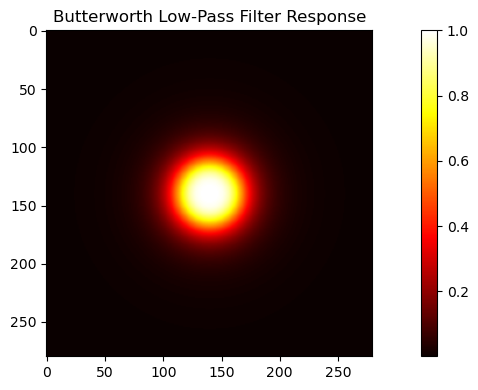

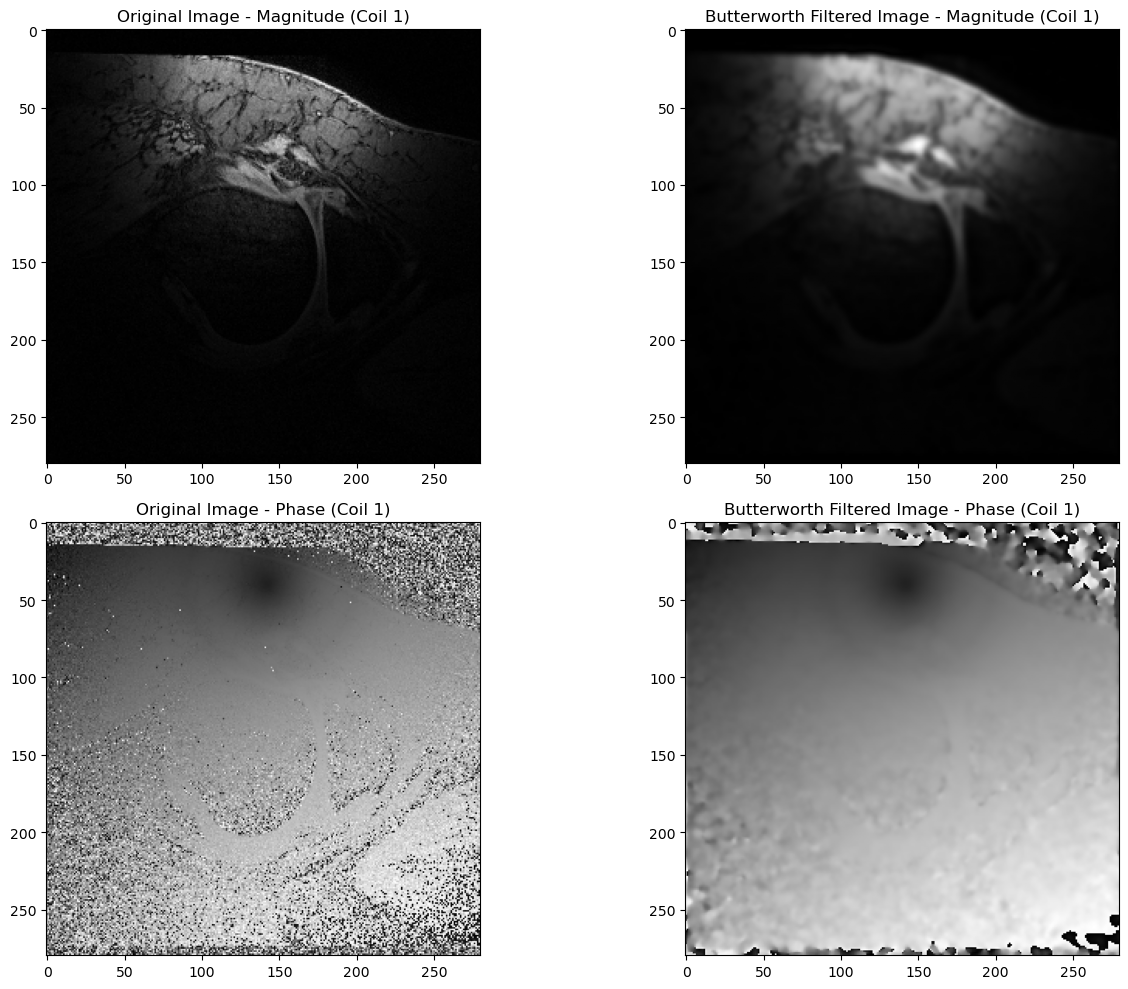


Butterworth Filter Metrics for Coil 1:
PSNR: 29.21 dB
SSIM: 0.827


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_bilateral, denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Define the data directory
data_dir = Path('../data/Module2')

# Load the k-space data
kspace_data = np.load(data_dir / 'kspace.npy')

# Print the shape of the data
print(f"Shape of k-space data: {kspace_data.shape}")
print(f"Data type: {kspace_data.dtype}")

# Find the coil dimension
coil_dim = None
for i, dim_size in enumerate(kspace_data.shape):
    if dim_size == 6:
        coil_dim = i
        print(f"Dimension {i} has size 6, which likely corresponds to the coil dimension")
        coil_dim = i
        break

# Number of coils
n_coils = kspace_data.shape[coil_dim]
print(f"Number of coils: {n_coils}")
print(f"Coil dimension: {coil_dim}")

# Function to get data for a specific coil
def get_coil_data(data, coil_dim, coil_idx):
    if coil_dim == 0:
        return data[coil_idx, :, :]
    elif coil_dim == 1:
        return data[:, coil_idx, :]
    else:  # coil_dim == 2
        return data[:, :, coil_idx]

# Transform k-space data to image space for all coils
image_data = np.zeros_like(kspace_data)
for coil_idx in range(n_coils):
    # Get k-space data for this coil
    coil_kspace = get_coil_data(kspace_data, coil_dim, coil_idx)
    
    # Apply inverse Fourier transform
    coil_image = np.fft.ifft2(coil_kspace)
    
    # Store in the image data array
    if coil_dim == 0:
        image_data[coil_idx, :, :] = coil_image
    elif coil_dim == 1:
        image_data[:, coil_idx, :] = coil_image
    else:  # coil_dim == 2
        image_data[:, :, coil_idx] = coil_image

# Apply Butterworth filter to k-space data for the first coil
def butterworth_lowpass_filter(shape, D0=30, n=2):
    P, Q = shape[0], shape[1]
    u = np.arange(P) - P // 2
    v = np.arange(Q) - Q // 2
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0) ** (2 * n))
    return H

# Get k-space data for the first coil
first_coil_kspace = get_coil_data(kspace_data, coil_dim, 0)

# Create Butterworth filter
filter_shape = first_coil_kspace.shape
butterworth_filter = butterworth_lowpass_filter(filter_shape, D0=30, n=2)  # D0 controls the cutoff frequency

# Shift k-space data to center
first_coil_kspace_shifted = np.fft.fftshift(first_coil_kspace)

# Apply filter to centered k-space data
filtered_kspace_shifted = first_coil_kspace_shifted * butterworth_filter

# Shift back
filtered_kspace = np.fft.ifftshift(filtered_kspace_shifted)

# Transform to image domain
filtered_image = np.fft.ifft2(filtered_kspace)

# Show Butterworth filter response
plt.figure(figsize=(10, 4))
plt.imshow(butterworth_filter, cmap='hot')
plt.colorbar()
plt.title('Butterworth Low-Pass Filter Response')
plt.tight_layout()
plt.show()

# Compare original and filtered images for the first coil (magnitude and phase)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original magnitude
original_image = get_coil_data(image_data, coil_dim, 0)
axes[0, 0].imshow(np.abs(original_image), cmap='gray')
axes[0, 0].set_title('Original Image - Magnitude (Coil 1)')

# Filtered magnitude
axes[0, 1].imshow(np.abs(filtered_image), cmap='gray')
axes[0, 1].set_title('Butterworth Filtered Image - Magnitude (Coil 1)')

# Original phase
axes[1, 0].imshow(np.angle(original_image), cmap='gray')
axes[1, 0].set_title('Original Image - Phase (Coil 1)')

# Filtered phase
axes[1, 1].imshow(np.angle(filtered_image), cmap='gray')
axes[1, 1].set_title('Butterworth Filtered Image - Phase (Coil 1)')

plt.tight_layout()
plt.show()

# Calculate metrics for Butterworth filter
original_magnitude = np.abs(original_image)
filtered_magnitude = np.abs(filtered_image)
mag_min, mag_max = np.min(original_magnitude), np.max(original_magnitude)

butterworth_psnr = psnr(original_magnitude, filtered_magnitude, data_range=mag_max-mag_min)
butterworth_ssim = ssim(original_magnitude, filtered_magnitude, data_range=mag_max-mag_min)

print(f"\nButterworth Filter Metrics for Coil 1:")
print(f"PSNR: {butterworth_psnr:.2f} dB")
print(f"SSIM: {butterworth_ssim:.3f}")



### 2.2.3 Recreate a new combined image using Wavelet

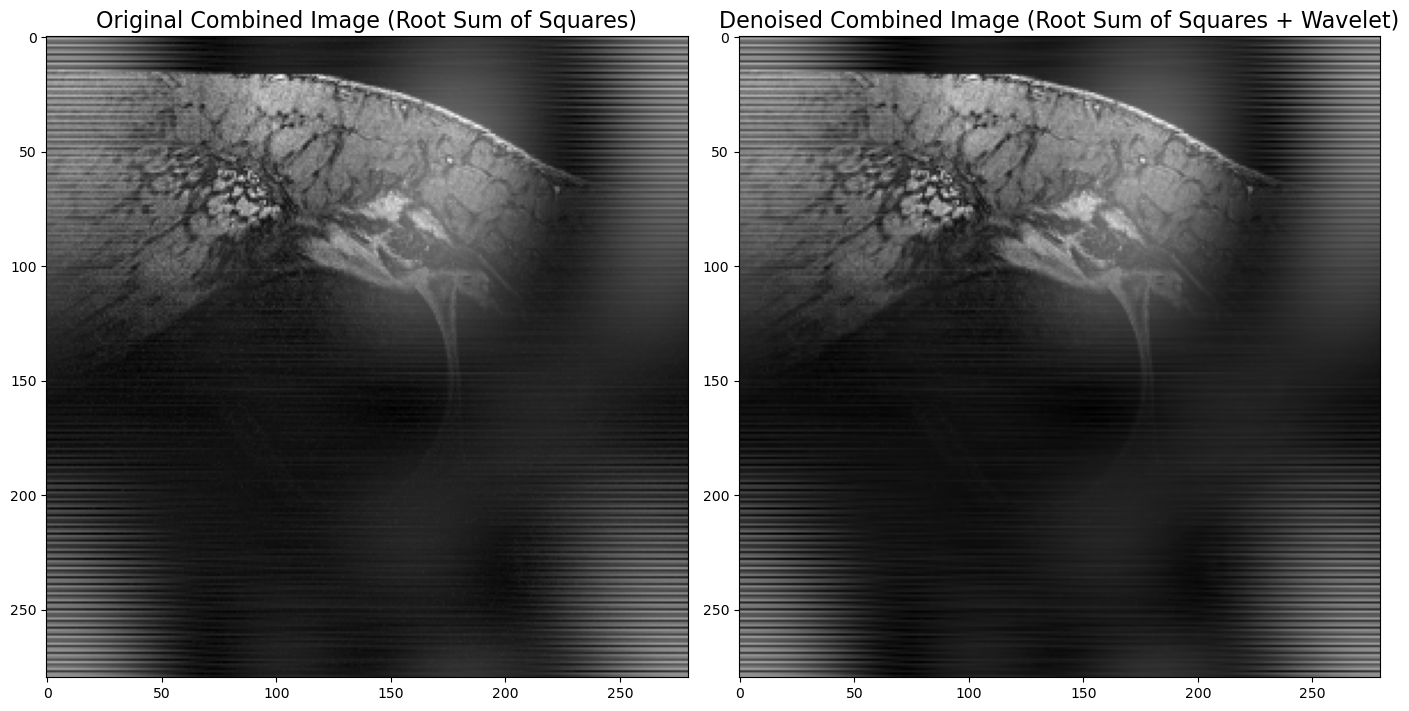


Combined Image Metrics:
PSNR: 44.70 dB
SSIM: 0.988


In [12]:
# We'll use the wavelet denoising as it often provides a good balance of noise reduction and detail preservation

# Apply wavelet denoising to all coils
denoised_images = np.zeros_like(image_data, dtype=np.complex128)

for coil_idx in range(n_coils):
    # Get image data for this coil
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    
    # Apply denoising to magnitude and preserve phase
    magnitude = np.abs(coil_image)
    phase = np.angle(coil_image)
    
    # Normalize magnitude for wavelet denoising
    mag_min, mag_max = np.min(magnitude), np.max(magnitude)
    magnitude_norm = (magnitude - mag_min) / (mag_max - mag_min) if mag_max > mag_min else magnitude
    
    # Apply wavelet denoising
    denoised_magnitude = denoise_wavelet(magnitude_norm, wavelet='db4', mode='soft', channel_axis=None)
    
    # Denormalize
    denoised_magnitude = denoised_magnitude * (mag_max - mag_min) + mag_min
    
    # Recombine with original phase
    denoised_complex = denoised_magnitude * np.exp(1j * phase)
    
    # Store in the denoised images array
    if coil_dim == 0:
        denoised_images[coil_idx, :, :] = denoised_complex
    elif coil_dim == 1:
        denoised_images[:, coil_idx, :] = denoised_complex
    else:  # coil_dim == 2
        denoised_images[:, :, coil_idx] = denoised_complex



# Create a combined image using root sum of squares (rSOS)
# Original combined image
combined_original = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_original += np.abs(coil_image)**2

combined_original = np.sqrt(combined_original)

# Denoised combined image
combined_denoised = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(denoised_images, coil_dim, coil_idx)
    combined_denoised += np.abs(coil_image)**2

combined_denoised = np.sqrt(combined_denoised)

# Compare original and denoised combined images
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original combined
axes[0].imshow(combined_original, cmap='gray')
axes[0].set_title('Original Combined Image (Root Sum of Squares)', fontsize = 16)

# Denoised combined
axes[1].imshow(combined_denoised, cmap='gray')
axes[1].set_title('Denoised Combined Image (Root Sum of Squares + Wavelet)', fontsize = 16)

plt.tight_layout()
plt.show()

# Calculate metrics for combined images
combined_psnr = psnr(combined_original, combined_denoised, data_range=np.max(combined_original)-np.min(combined_original))
combined_ssim = ssim(combined_original, combined_denoised, data_range=np.max(combined_original)-np.min(combined_original))

print(f"\nCombined Image Metrics:")
print(f"PSNR: {combined_psnr:.2f} dB")
print(f"SSIM: {combined_ssim:.3f}")


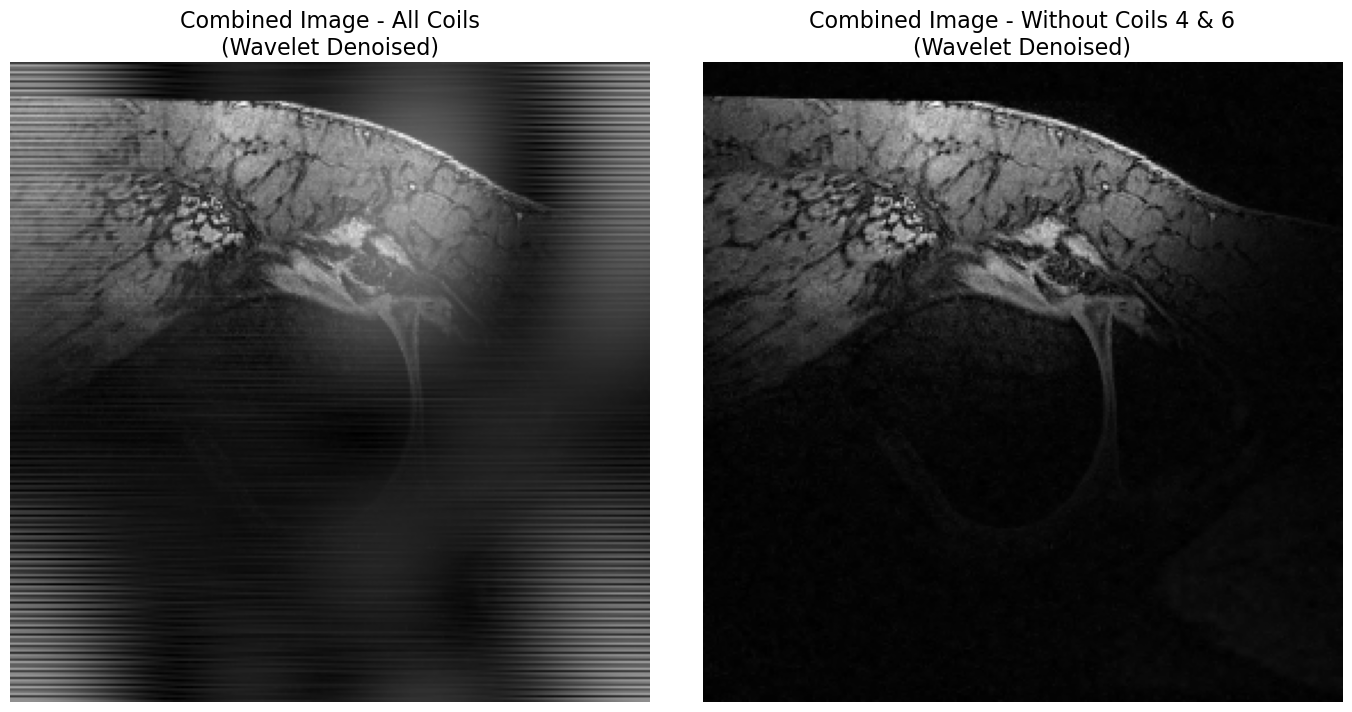


Comparison Metrics - Selected Coils vs All Coils:
PSNR: 15.04 dB
SSIM: 0.501


In [13]:
# Create a combined image using root sum of squares (rSOS) with wavelet denoising
# First, combine all coils
combined_all_coils = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(denoised_images, coil_dim, coil_idx)
    combined_all_coils += np.abs(coil_image)**2

combined_all_coils = np.sqrt(combined_all_coils)

# Now combine selected coils (skipping coils 4 and 6)
combined_selected_coils = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    if coil_idx not in [3, 5]:  # Skip coil 4 and 6 (0-indexed as 3 and 5)
        coil_image = get_coil_data(denoised_images, coil_dim, coil_idx)
        combined_selected_coils += np.abs(coil_image)**2

combined_selected_coils = np.sqrt(combined_selected_coils)

# Compare the two combined images
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# All coils combined
axes[0].imshow(combined_all_coils, cmap='gray')
axes[0].set_title('Combined Image - All Coils\n(Wavelet Denoised)', fontsize = 16)
axes[0].axis('off')

# Selected coils combined (skipping 4 and 6)
axes[1].imshow(combined_selected_coils, cmap='gray')
axes[1].set_title('Combined Image - Without Coils 4 & 6\n(Wavelet Denoised)', fontsize = 16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics for comparison
selected_vs_all_psnr = psnr(combined_all_coils, combined_selected_coils, 
                           data_range=np.max(combined_all_coils)-np.min(combined_all_coils))
selected_vs_all_ssim = ssim(combined_all_coils, combined_selected_coils, 
                           data_range=np.max(combined_all_coils)-np.min(combined_all_coils))

print(f"\nComparison Metrics - Selected Coils vs All Coils:")
print(f"PSNR: {selected_vs_all_psnr:.2f} dB")
print(f"SSIM: {selected_vs_all_ssim:.3f}")

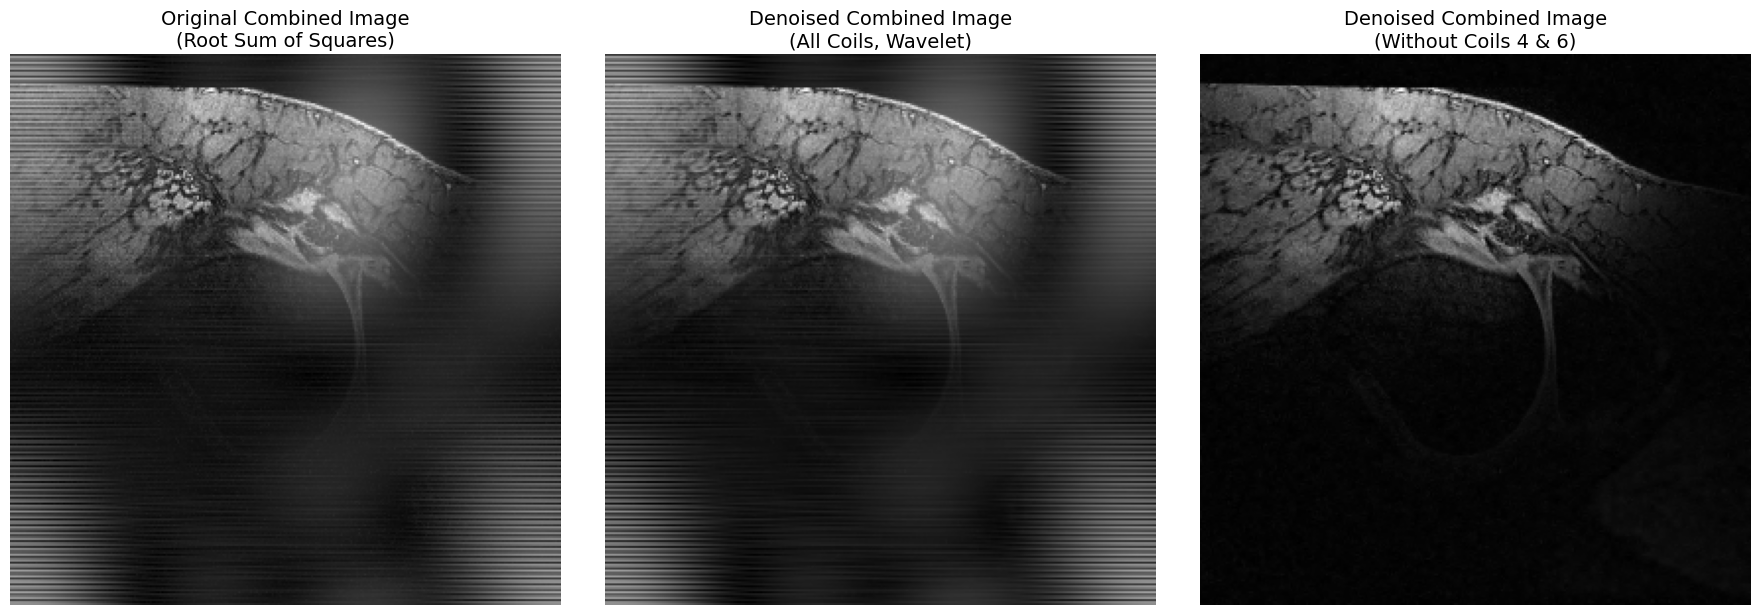

In [14]:
# Compute 3 images
# 1. Original combined image
combined_original = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(image_data, coil_dim, coil_idx)
    combined_original += np.abs(coil_image)**2
combined_original = np.sqrt(combined_original)

# 2. Wavelet-denoised, all coils
combined_denoised = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    coil_image = get_coil_data(denoised_images, coil_dim, coil_idx)
    combined_denoised += np.abs(coil_image)**2
combined_denoised = np.sqrt(combined_denoised)

# 3. Wavelet-denoised, without coils 4 and 6 (index 3 and 5)
combined_selected = np.zeros(original_image.shape, dtype=np.float64)
for coil_idx in range(n_coils):
    if coil_idx not in [3, 5]:  # skip 4 & 6
        coil_image = get_coil_data(denoised_images, coil_dim, coil_idx)
        combined_selected += np.abs(coil_image)**2
combined_selected = np.sqrt(combined_selected)

# Plot all 3 in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Original
axes[0].imshow(combined_original, cmap='gray')
axes[0].set_title('Original Combined Image (Root Sum of Squares)', fontsize=14)
axes[0].axis('off')

# 2. All coils + wavelet
axes[1].imshow(combined_denoised, cmap='gray')
axes[1].set_title('Denoised Combined Image\n(All Coils, Wavelet)', fontsize=14)
axes[1].axis('off')

# 3. Selective coils
axes[2].imshow(combined_selected, cmap='gray')
axes[2].set_title('Denoised Combined Image\n(Without Coils 4 & 6)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()


### 2.2.4 Compare k-space vs image-based denoising methods

1. Butterworth Filter (K-space domain):
   - Directly operates on the frequency domain information
   - Suppresses high-frequency components which often correspond to noise
   - Preserves low-frequency structural information effectively
   - Can result in smoother transitions and reduced noise
   - May cause blurring of fine details and edges as it is a non-adaptive filter
   - The uniform cutoff frequency doesn't account for local image features

2. Image-based Methods (e.g., Wavelet):
   - Operate after the inverse Fourier transform in the spatial domain
   - Can be more adaptive to local image features
   - Better at preserving edges and structural details
   - Wavelet denoising in particular works across multiple scales
   - May leave some noise untouched in complex regions

Relative Advantages:
   - Butterworth filtering is computationally efficient
   - Image-based methods like wavelet denoising are better at preserving important features
   - K-space filtering affects the entire image in a predictable way
   - Spatial domain methods can be more selective about what to denoise


Methods to Further Improve Combined Image Quality:
1. Advanced Combination Methods:
   - Adaptive coil combination: Weighting each coil's contribution based on local SNR
   - SENSE or GRAPPA reconstruction: Leveraging coil sensitivities for better combination
   - Optimal B1 filtering: Accounting for coil sensitivity profiles

2. Hybrid Denoising Approaches:
   - Apply different denoising methods to different spatial frequency bands
   - Combine k-space and image domain methods sequentially
   - Use noise correlation matrix to improve combination

3. Deep Learning Methods:
   - Convolutional Neural Networks (CNNs) trained on paired noisy/clean data
   - Variational Autoencoders (VAEs) for unsupervised denoising
   - U-Net architectures specifically designed for medical image enhancement
   - Learn optimal coil combination weights

4. Regularization Techniques:
   - Total Variation (TV) regularization to preserve edges while removing noise
   - Dictionary learning methods like K-SVD
   - Non-local means filtering with adaptive patch sizes

5. Phase-based Improvements:
   - Phase-preserving denoising methods
   - Unwrapping phase before denoising to avoid phase artifacts
   - Using magnitude and phase information together for better reconstruction

6. Acquisition-based Improvements:
   - Optimized k-space sampling patterns
   - Prospective motion correction
   - Higher field strengths for better SNR